<a href="https://colab.research.google.com/github/silo86/time_series_analysis_on_sunspot_dataset/blob/main/time_series_analysis_on_sunspot_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 42.4MB/s]


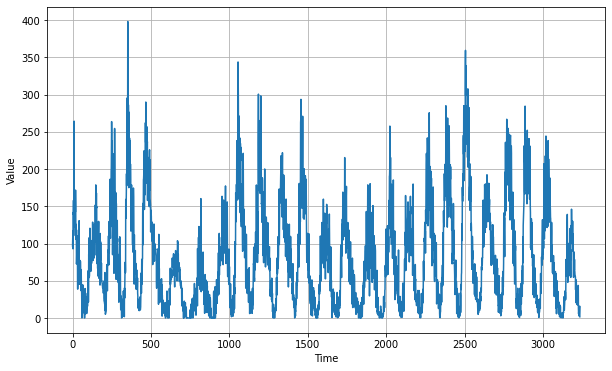

In [4]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time=3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset (series,window_size,batch_size,shuffle_buffer_size):
  ds = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.window(size=window_size,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w: (w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train,window_size=window_size,batch_size=batch_size,shuffle_buffer_size=shuffle_buffer_size)

In [9]:
model = tf.keras.Sequential([
                     tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=5,
                                            strides=1,
                                            activation='relu',
                                            padding='causal',
                                            input_shape=[None,1]
                     ),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                     tf.keras.layers.Dense(30,activation='relu'),
                     tf.keras.layers.Dense(10,activation='relu'),
                     tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae']
)
history = model.fit(train_set,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 26s 124ms/step - loss: 82.7355 - mae: 83.2240 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 88ms/step - loss: 82.7355 - mae: 83.2240 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 90ms/step - loss: 82.7355 - mae: 83.2240 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 91ms/step - loss: 82.7355 - mae: 83.2239 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 93ms/step - loss: 82.7354 - mae: 83.2239 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 92ms/step - loss: 82.7354 - mae: 83.2239 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 87ms/step - loss: 82.7353 - mae: 83.2238 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 89ms/step - loss: 82.7353 - mae: 83.2238 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 1s 89ms/step - loss: 82.7352 - ma

(0.0001, 0.001, 25.0, 60.0)

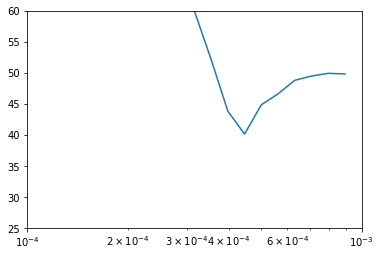

In [10]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-3,25,60])

In [11]:
model = tf.keras.Sequential([
                     tf.keras.layers.Conv1D(filters=32,
                                            kernel_size=5,
                                            strides=1,
                                            activation='relu',
                                            padding='causal',
                                            input_shape=[None,1]
                     ),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                     tf.keras.layers.Dense(30,activation='relu'),
                     tf.keras.layers.Dense(10,activation='relu'),
                     tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-4,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae']
)
history = model.fit(train_set,
                    epochs=500
                    )

Epoch 1/500
12/12 [==============================] - 8s 89ms/step - loss: 82.1851 - mae: 82.6760
Epoch 2/500
12/12 [==============================] - 1s 92ms/step - loss: 81.1095 - mae: 81.6043
Epoch 3/500
12/12 [==============================] - 1s 89ms/step - loss: 79.3868 - mae: 79.8833
Epoch 4/500
12/12 [==============================] - 1s 90ms/step - loss: 76.2357 - mae: 76.7325
Epoch 5/500
12/12 [==============================] - 1s 90ms/step - loss: 70.4622 - mae: 70.9587
Epoch 6/500
12/12 [==============================] - 1s 92ms/step - loss: 61.3705 - mae: 61.8680
Epoch 7/500
12/12 [==============================] - 1s 91ms/step - loss: 51.8151 - mae: 52.3129
Epoch 8/500
12/12 [==============================] - 1s 89ms/step - loss: 42.4285 - mae: 42.9258
Epoch 9/500
12/12 [==============================] - 1s 91ms/step - loss: 33.6587 - mae: 34.1540
Epoch 10/500
12/12 [==============================] - 1s 91ms/step - loss: 34.5382 - mae: 35.0325
Epoch 11/500
12/12 [=========

(400.0, 500.0, 0.0, 20.0)

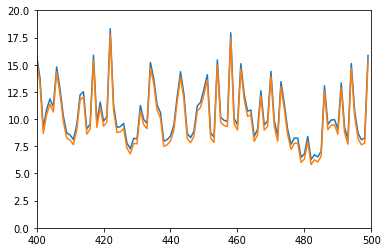

In [12]:
mae = history.history['mae']
loss = history.history['loss']
plt.plot(mae)
plt.plot(loss)
plt.axis([400,500,0,20])

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

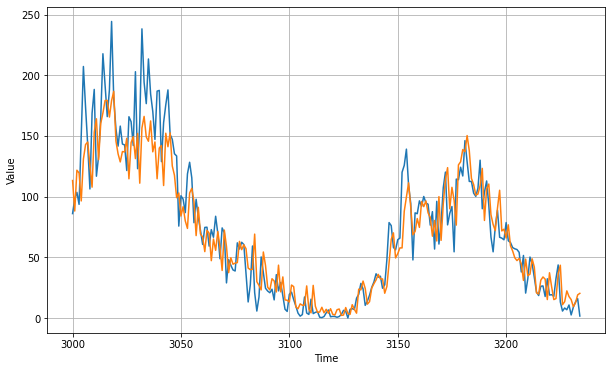

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

16.075092

<Figure size 432x288 with 0 Axes>

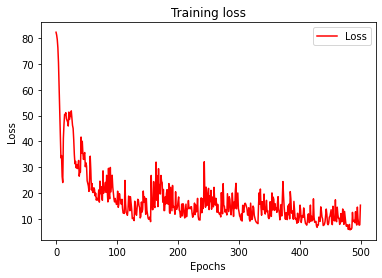

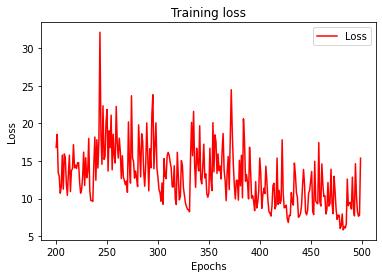

<Figure size 432x288 with 0 Axes>

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()